In [1]:
from prince import PCA, MCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from os import path
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter,defaultdict
from clean_functions import merge_questions,split_per_pilot, filter_site_outliers
from matplotlib.lines import Line2D
import os

In [2]:
dataset_path = os.getenv("DATASET_PATH")
questions_path = os.getenv('QUESTION_PATH')
plot_folder = os.getenv('PLOT_FOLDER')

df_t0 = pd.read_csv(dataset_path, sep=';')
complete_df = merge_questions(df_t0)
pilot_col = complete_df.pilot

In [5]:
questions_t0 = pd.read_csv(questions_path, sep=';')
discard_questions = []
for row in questions_t0.itertuples():
    if row.type in {'multiple', 'text', 'longtext'}:
        discard_questions.append(row.number)

In [6]:
clean_complete_df = complete_df.drop(discard_questions+['id', 'pilot', 'internal_code'], axis=1)

# Current value analysis

In [7]:
columns = [f'Q{q}' for q in clean_complete_df.columns.values]
pca = PCA(n_components=3)
imputer = IterativeImputer()
scaler = StandardScaler()
scaled_df = pd.DataFrame(data=scaler.fit_transform(imputer.fit_transform(clean_complete_df)), columns=columns)
pca_data = pca.fit_transform(scaled_df)

/Users/toniblascocalafat/anaconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [8]:
non_outliers_dfs = []
dataframes = split_per_pilot(pca_data, pilot_col)
# For every site dataframe, left only the x, y and z variables to calculate outliers
for df in dataframes:
    df_not_outlier = filter_site_outliers(df)
    non_outliers_dfs.append(df_not_outlier)
pca_data = pd.concat(non_outliers_dfs)

In [9]:
questions_per_category=defaultdict(list)
for i, row in questions_t0.iterrows():
    category = row['group']
    number = row['number']
    questions_per_category[category].append(f'Q{number}')

In [10]:
contributions = pca.column_contributions_
contributions['total'] = contributions[0]+contributions[1]+contributions[2]
contributions.sort_values(by='total', ascending=False).head(20).index

Index(['Q136', 'Q88', 'Q104', 'Q134', 'Q108', 'Q168', 'Q106', 'Q100', 'Q94',
       'Q92', 'Q105', 'Q90', 'Q103', 'Q98', 'Q107', 'Q97', 'Q96', 'Q73', 'Q99',
       'Q102'],
      dtype='object', name='variable')

# Missing try!

In [11]:
NOT_MISSING = 0
NOT_APPLY = 1
MISSING = 2

def create_missing_type_matrix(df):
    outcome_df = []
    new_row = dict()
    for row in df.to_dict(orient="records"):
        for column, value in row.items():
            if not pd.isnull(value) and isinstance(value, float) and value >= 0:
                new_row[column] = NOT_MISSING
                continue
            # It's columns - 1 because the first question is 1 in line 0
            depends_on = questions_t0.depends_on[column-1]
            if pd.isnull(depends_on):
                new_row[column] = MISSING
                continue
            
            depends_on = int(depends_on)
            deactivate_values = [int(dv) for dv in questions_t0.deactivate_values[column-1].split(',')]
        
            # Pick the previous value!
            previous_value = row[depends_on]
            if previous_value in deactivate_values:
                new_row[column] = NOT_APPLY  
            else:
                new_row[column] = MISSING
        # end of iterating over the row
        outcome_df.append(new_row)
        new_row = dict()
    return pd.DataFrame(outcome_df)

In [12]:
missing_df = create_missing_type_matrix(clean_complete_df)
new_headers = [f'Q{q}' for q in missing_df.columns.values]

In [13]:
mca = MCA(n_components=3,
                         n_iter=3,
                         copy=True,
                         check_input=True,
                         engine='sklearn')
mca_df = mca.fit_transform(missing_df)
non_outliers_dfs = []
dataframes = split_per_pilot(mca_df, pilot_col)
# For every site dataframe, left only the x, y and z variables to calculate outliers
for df in dataframes:
    df_not_outlier = filter_site_outliers(df)
    non_outliers_dfs.append(df_not_outlier)
mca_df = pd.concat(non_outliers_dfs)

In [14]:
def add_contributions(contributions):
    clean_index = sorted(list({int(i.split('_')[0]) for i in contributions.index}))
    clean_index = [f'Q{j}' for j in clean_index]
    new_contributions = {}
    for row in contributions.itertuples():
        ind = int(row.Index.split('_')[0])
        if ind in new_contributions:
            new_contributions[ind][0] += row._1
            new_contributions[ind][1] += row._2
            new_contributions[ind][2] += row._3
        else:
            new_contributions[ind] = {0: row._1, 1: row._2, 2: row._3}
    df = pd.DataFrame(new_contributions.values())
    df['ind'] = clean_index
    return df.set_index('ind')

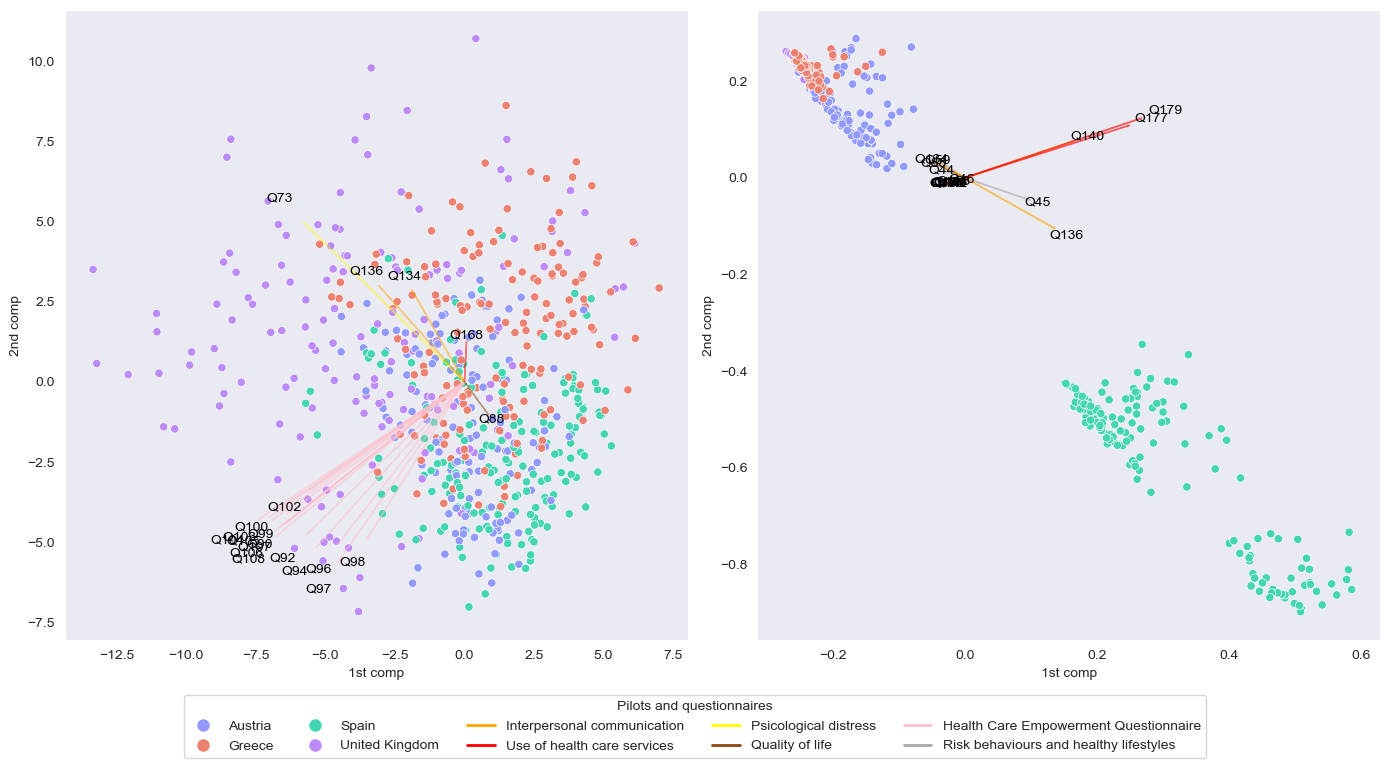

In [19]:
def biplot2d(first_dim, second_dim, color_col, loadings, contributions, columns, questions_per_category, ax, plot_label):
    # plotly colors
    sns.set_style("white")
    colors = ['#9199fb', '#ec8172', '#44d5b2', '#bc8bf8']
    sns.set_palette(sns.color_palette(colors))
    
    contributions['total'] = contributions[0] + contributions[1] + contributions[2]
    most_contributed = set(contributions.sort_values(by='total', ascending=False).head(20).index)
    questionnaire_representation = defaultdict(list)
    _ = [questionnaire_representation[group].append(variable) for variable in most_contributed for group, questions in questions_per_category.items() if variable in questions]
    
    # Scatterplot
    scatter = sns.scatterplot(x=first_dim, y=second_dim, hue=color_col, ax=ax, legend=False) 
    ax.set_xlabel('1st comp')
    ax.set_ylabel('2nd comp')
    ax.grid(False)
    
    # Colores por categoría
    category_colors = {
        'Interpersonal communication': '#FFA500',  # Orange
        'Use of health care services': '#FF0000',  # Red
        'Psicological distress': '#FFFF00',  # Yellow
        'Quality of life': '#8B4513',  # Brown
        'Health Care Empowerment Questionnaire': '#FFC0CB',  # Pink
        'Risk behaviours and healthy lifestyles' : '#A9A9A9',  # Grey
        'default': '#000000' #Black
    }

    for i, feature in enumerate(columns):
        if feature in most_contributed:
            for category, questions in questionnaire_representation.items():
                if feature in questions:
                    color = category_colors.get(category, category_colors['default'])
                    ax.arrow(0, 0, loadings[0, i], loadings[1, i], color=color, alpha=0.5)
                    ax.text(loadings[0, i]*1.15, loadings[1, i]*1.15, feature, color='black', ha='center', va='center')
    
    return list(color_col.unique()), list(sns.color_palette()[:len(color_col.unique())]), plot_label, category_colors

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

loadings_pca = (pca.svd_.V.copy().T * pca.eigenvalues_).T
loadings_pca *= 3
pca_data = [pca_data[0], pca_data[1], pilot_col, loadings_pca, pca.column_contributions_]

loadings_mca = (mca.svd_.V.copy().T * mca.eigenvalues_).T
loadings_mca *= 7
mca_data = [mca_df[0], mca_df[1], pilot_col, loadings_mca, add_contributions(mca.column_contributions_)]

pca_labels, pca_colors, pca_label, category_colors = biplot2d(pca_data[0], pca_data[1], pilot_col, loadings_pca, pca.column_contributions_, columns, questions_per_category, ax=axes[0], plot_label='PCA')

mca_labels, mca_colors, mca_label, _ = biplot2d(mca_df[0], mca_df[1], pilot_col, loadings_mca, add_contributions(mca.column_contributions_), columns, questions_per_category, ax=axes[1], plot_label='MCA')


handles_data = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in pca_colors]
labels_data = pca_labels  

handles_category = [Line2D([0], [0], color=color, lw=2) for category, color in category_colors.items() if category != 'default']
labels_category = [category for category in category_colors if category != 'default']

handles_combined = handles_data + handles_category
labels_combined = labels_data + labels_category

fig.legend(handles=handles_combined, 
           labels=labels_combined, 
           loc='lower center',
           bbox_to_anchor=(0.5, -0.1),
           ncol=5,
           title='Pilots and questionnaires')
plt.tight_layout()
plt.savefig(path.join(plot_folder, 'last_figure.png'))
plt.show()